# Exploring Autoencoder for embedding

## Import necessary dependencies 

In [1]:
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import customize_dataloader as cd

import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import os
import torchvision

import seaborn as sns
from PIL import Image

c:\Anaconda\envs\curationsystem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print("CUDA is available. GPU(s) found.")
    print("CUDA devices:")
    for i in range(torch.cuda.device_count()):
        print(f"  - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Only CPU is being used.")

CUDA is available. GPU(s) found.
CUDA devices:
  - NVIDIA GeForce RTX 3070 Ti


## Import dataset

In [81]:
# Adjust the paths to where your datasets are located
train_df = pd.read_csv('./SemArt/semart_test.csv', sep='\t', encoding='ISO-8859-1')
val_df = pd.read_csv('./SemArt/semart_val.csv', sep='\t', encoding='ISO-8859-1')
test_df = pd.read_csv('./SemArt/semart_test.csv', sep='\t', encoding='ISO-8859-1')

In [4]:
all_data_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [5]:
all_data_df

,IMAGE_FILE,DESCRIPTION,AUTHOR,TITLE,TECHNIQUE,DATE,TYPE,SCHOOL,TIMEFRAME
0,41294-10ladisl.jpg,Of the Hungarian kings St Ladislas is perhaps ...,"UNKNOWN MASTER, Hungarian","Saint Ladislaus, King of Hungary","Oil on wood, 103 x 101,3 cm",c. 1600,religious,Hungarian,1551-1600
1,42791-1sacris.jpg,This ceiling painting in the sacristy of San S...,"VERONESE, Paolo",Coronation of the Virgin,"Oil on canvas, 200 x 170 cm",1555,religious,Italian,1551-1600
2,14376-worship.jpg,In the same period when the most talented arti...,"FRANCKEN, Frans II",Worship of the Golden Calf,"Oil on panel, 60 x 88 cm",-,religious,Flemish,1601-1650
3,24776-annuncia.jpg,Based on its style the Annunciation is attribu...,MASTER of Flémalle,Annunciation,"Tempera on oak, 61 x 63,7 cm",1420s,religious,Flemish,1401-1450
4,23845-3manet04.jpg,The 1870s were rich in female models for Manet...,"MANET, Edouard",Brunette with Bare Breasts,"Oil on canvas, 60 x 49 cm",c. 1872,portrait,French,1851-1900
...,...,...,...,...,...,...,...,...,...
3202,08082-gondola.jpg,In this painting Carus also shows the figures ...,"CARUS, Carl Gustav",A Gondola on the Elbe near Dresden,"Oil on canvas, 29 x 22 cm",1827,landscape,German,1801-1850
3203,32349-17ignazi.jpg,The effect of the simulated cupola rests large...,"POZZO, Andrea",Painting on the pendentive: Samson,Fresco,1685,religious,Italian,1651-1700
3204,35839-valkhof1.jpg,The picture shows the Valkhof at Nijmegen with...,"RUYSDAEL, Salomon van",The Valkhof at Nijmegen,"Oil on canvas, 73 x 103 cm",1650s,landscape,Dutch,1601-1650
3205,40789-crucifix.jpg,This unusually violent Crucifix was probably t...,"UNKNOWN MASTER, Bohemian",Crucifixion,"Panel, 67 x 30 cm",c. 1360,religious,Bohemian,1351-1400


In [6]:
all_data_df.to_csv("./SemArt/semart_desc_all.csv", index=False, sep='\t', encoding='utf-8')

In [7]:
all_data_df.iloc[0]['IMAGE_FILE']

'41294-10ladisl.jpg'

## Define Custom dataset

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

###############################################################################
# Data Loading
def get_data_loader(batch_size=64,num_workers=1, 
                    resize=transforms.Resize((224,224)),
                    normailze = False):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        path: path to the wikiART224 image folder that has a bunch of 
        batch size: set batchsize for the loaders
        num_workers size: set num_workers for the loaders
        overfit: for testing purposes where we try small dataset that test the 
        model capability of overfitting. 

    Returns:
        raw_dataset: iterable dataset that get the whole instance of the dataset
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    if normailze == True:
        transform = transforms.Compose(
            [resize,transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
        transform = transforms.Compose(
            [resize,transforms.ToTensor()]
            )

    raw_dataset = ImageFolder(root='./SemArt/all_image', transform=transform)

    # Get the list of indices to sample from
    #relevant_indices = get_relevant_indices(raw_dataset, classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    indices = np.arange(len(raw_dataset))
    np.random.shuffle(indices)
    train_split = int(len(indices) * 0.8)

    # dividing by 2 will assign 10% to val and 10% to test
    # if the train is 0.8
    testval_split = train_split + int(len(indices) * (1 - 0.8)/2)

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                               num_workers=num_workers, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                              num_workers=num_workers, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=test_sampler)
    

    return raw_dataset, train_loader, val_loader, test_loader

Test datalaoder

In [58]:
raw_dataset, train_loader, val_loader, test_loader,_ = cd.get_data_loader("./SemArt/all_image",batch_size=5,resize=transforms.Resize((224,224)),normailze = True)
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  3422
validation examples:  428
testing examples:  428


## Autoencoder

#### Visualization

In [14]:
def visualize(inputs, outputs, use_gpu=False, n=10):
    """
    Visualize the original images, their expected outputs, and the model predictions.

    Args:
      inputs (tensor): The original images.
      targets (tensor): The true outputs (for an autoencoder, this could be the same as inputs).
      outputs (tensor): The model's predictions.
      use_gpu (bool): Flag indicating whether the tensors are on a GPU.
      n (int): Number of samples to visualize.
    """
    if use_gpu:
        inputs = inputs.cpu()
        outputs = outputs.cpu()

    inputs = inputs.numpy()[:n].transpose((0, 2, 3, 1))
    outputs = outputs.detach().numpy()[:n].transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(2, n, figsize=(n*2, 6))
    if n == 1:
        axes = np.expand_dims(axes, 1)  # Make sure axes is 2D array
    
    for i in range(n):
        for ax, img, title in zip(axes[:, i], [inputs[i], outputs[i]], ['Input', 'Output']):
            ax.imshow(np.clip(img, 0, 1))
            ax.set_title(title)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


#### Train code

In [51]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    _, train_loader, _, _, _ = cd.get_data_loader("./SemArt/all_image",batch_size=args.batch_size,resize=args.resize)

    #print("Transforming data...")
    #train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    #test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()

    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, data in enumerate(train_loader,0):
            inputs, _,_,_= data

            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              inputs = inputs.cuda()
            #############################################

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(inputs)

            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        print(epoch, loss.cpu().detach())
        #if epoch%5 == 0 and args.plot:
        visualize(inputs, outputs, args.gpu, 1)
        # Save the model state dictionary
        model_save_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
        torch.save(gen.state_dict(), model_save_path)

    return gen

#### Architecture

In [3]:
class UNetEncoder(nn.Module):
    def __init__(self, kernel, num_filters, num_in_channels=3):
        super(UNetEncoder, self).__init__()
        stride = 2
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.downconv3(x2)
        x_rf = self.rfconv(x3)
        return x1, x2, x3, x_rf


In [4]:
class UNetDecoder_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNetDecoder_simp, self).__init__()
        padding = kernel // 2

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.finalconv = nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x1, x2, x3, x_rf, original_x):
        x_up1 = self.upconv1(x_rf)
        x_up1_skip = torch.cat([x_up1, x2], dim=1)
        x_up2 = self.upconv2(x_up1_skip)
        x_up3 = self.upconv3(x_up2)
        out = self.finalconv(x_up3)
        return out


In [5]:
class UNet_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNet_simp, self).__init__()
        self.encoder = UNetEncoder(kernel, num_filters, num_in_channels)
        self.decoder = UNetDecoder_simp(kernel, num_filters, num_colours, num_in_channels)

    def forward(self, x):
        x1, x2, x3, x_rf = self.encoder(x)
        out = self.decoder(x1, x2, x3, x_rf, x)
        return out


Loading data...
Beginning training ...
0 tensor(0.0069)


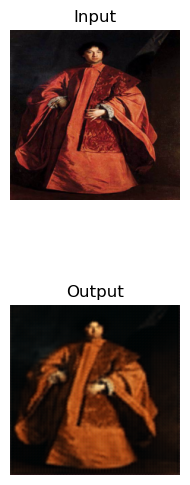

1 tensor(0.0033)


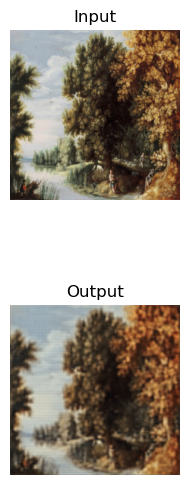

2 tensor(0.0023)


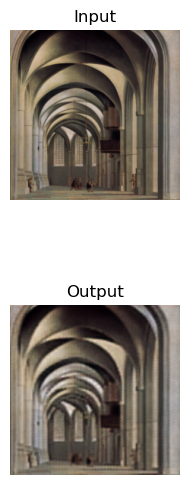

In [25]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "UNet_simp",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.01,
    "batch_size": 32,
    "epochs": 3,
    "seed": 0,
    "resize": transforms.Resize((224,224)),
    "plot": True,
    "experiment_name": "UNet_SEMART",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
unet_sem = train(args)

Test the recon on validation data

In [6]:
def visualize_reconstructions(model, data_loader, num_images=5):
    """
    Visualizes original and regenerated images using the given model and data from a DataLoader.
    
    Parameters:
    - model: The PyTorch model to use for image regeneration.
    - data_loader: DataLoader containing the dataset for visualization.
    - num_images: The number of images to visualize.
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Inference without gradient calculation
        for batch in data_loader:
            original_images, _, _, _ = batch  # Adjust if your DataLoader structure is different
            
            # Move data to GPU if available
            if torch.cuda.is_available():
                original_images = original_images.cuda()
            
            # Regenerate images
            regenerated_images = model(original_images).cpu()
            
            original_images = original_images.cpu()
            
            # Visualization loop
            fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
            for i in range(num_images):
                # Original Image
                original_img_np = original_images[i].permute(1, 2, 0).numpy()
                axes[0, i].imshow(original_img_np)
                axes[0, i].set_title(f'Original {i+1}')
                axes[0, i].axis('off')

                # Regenerated Image
                regenerated_img_np = regenerated_images[i].permute(1, 2, 0).numpy()
                axes[1, i].imshow(regenerated_img_np)
                axes[1, i].set_title(f'Regenerated {i+1}')
                axes[1, i].axis('off')

            plt.show()
            
            # Break after visualizing the first batch of the specified number of images
            break


## Load Model

In [6]:
# large
model = UNet_simp(kernel=3, num_filters=32, num_colours=3, num_in_channels=3)

In [7]:
# Ensure you're loading the model on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the state dictionary
model_state_dict = torch.load('./outputs/UNet_SEMART/model_epoch_2.pth', map_location=device)

# Update the model with the loaded state dictionary
model.load_state_dict(model_state_dict)
model.cuda()

UNet_simp(
  (encoder): UNetEncoder(
    (downconv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (downconv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (downconv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (rfconv): Sequential(
      (0): Conv

In [8]:
raw_dataset, train_loader, val_loader, test_loader,_ = cd.get_data_loader("./SemArt/all_image",batch_size=5,resize=transforms.Resize((224,224)),normailze = True)
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  3422
validation examples:  428
testing examples:  428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

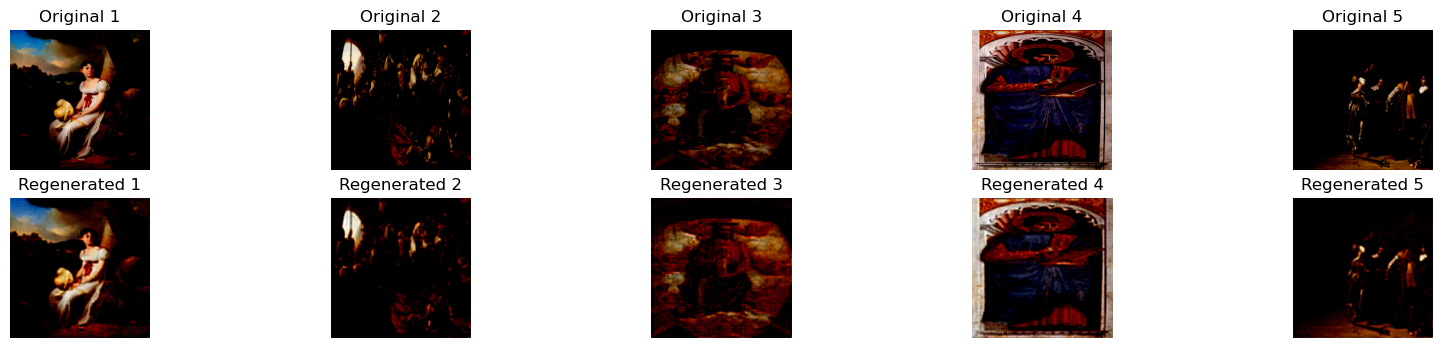

In [13]:
visualize_reconstructions(model,val_loader)

In [11]:
encoded_features = []
labels_list = []
file_name_list = [] 

for i, data in enumerate(val_loader, 0):
    inputs, labels, filenames, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l,fn in zip(vec, labels.numpy(),filenames):
        encoded_features.append(v)
        labels_list.append(l)
        file_name_list.append(fn)


In [12]:
for i, data in enumerate(test_loader, 0):
    inputs, labels, filenames, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l,fn in zip(vec, labels.numpy(),filenames):
        encoded_features.append(v)
        labels_list.append(l)
        file_name_list.append(fn)

In [13]:
for i, data in enumerate(train_loader, 0):
    inputs, labels, filenames, _ = data
    
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        model = model.cuda()
        
    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)
        
    # Assuming you want to use the bottleneck features, which is the last in the tuple
    vec = outputs[-1]  # This selects the last tensor from the tuple
    
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    
    # Collect the flattened features and labels
    for v, l,fn in zip(vec, labels.numpy(),filenames):
        encoded_features.append(v)
        labels_list.append(l)
        file_name_list.append(fn)

In [19]:
# Create DataFrame
df_embedding = pd.DataFrame({
    'Encoded Features': encoded_features,
    'IMAGE_FILE': file_name_list
})
print(df_embedding.shape)
# Convert the numpy arrays in 'array_column' to tuples
df_embedding.head()

(21384, 2)


,Encoded Features,IMAGE_FILE
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",02914-distress.jpg
1,"[0.45807198, 0.555539, 0.8111484, 0.96786785, ...",03466-2interio.jpg
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",07184-canal301.jpg
3,"[0.29540697, 0.1378976, 0.16437322, 0.18008024...",03384-stillif.jpg
4,"[0.08557064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",44113-freshpea.jpg


In [20]:
df_embedding["Encoded Features"][0]

array([0.        , 0.        , 0.        , ..., 0.35260388, 0.33736193,
       0.680636  ], dtype=float32)

In [39]:
df_embedding["Encoded Features"][0]

array([0.17394169, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

save embeddings

In [17]:
all_data_df = pd.read_csv('./SemArt/semart_desc_all.csv', sep='\t')
print(all_data_df.shape)
all_data_df.head()

(3207, 9)


,IMAGE_FILE,DESCRIPTION,AUTHOR,TITLE,TECHNIQUE,DATE,TYPE,SCHOOL,TIMEFRAME
0,41294-10ladisl.jpg,Of the Hungarian kings St Ladislas is perhaps ...,"UNKNOWN MASTER, Hungarian","Saint Ladislaus, King of Hungary","Oil on wood, 103 x 101,3 cm",c. 1600,religious,Hungarian,1551-1600
1,42791-1sacris.jpg,This ceiling painting in the sacristy of San S...,"VERONESE, Paolo",Coronation of the Virgin,"Oil on canvas, 200 x 170 cm",1555,religious,Italian,1551-1600
2,14376-worship.jpg,In the same period when the most talented arti...,"FRANCKEN, Frans II",Worship of the Golden Calf,"Oil on panel, 60 x 88 cm",-,religious,Flemish,1601-1650
3,24776-annuncia.jpg,Based on its style the Annunciation is attribu...,MASTER of Flémalle,Annunciation,"Tempera on oak, 61 x 63,7 cm",1420s,religious,Flemish,1401-1450
4,23845-3manet04.jpg,The 1870s were rich in female models for Manet...,"MANET, Edouard",Brunette with Bare Breasts,"Oil on canvas, 60 x 49 cm",c. 1872,portrait,French,1851-1900


In [18]:
#left join
df_joined = all_data_df.merge(df_embedding, on='IMAGE_FILE', how='left')
df_joined.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR,TITLE,TECHNIQUE,DATE,TYPE,SCHOOL,TIMEFRAME,Encoded Features
0,41294-10ladisl.jpg,Of the Hungarian kings St Ladislas is perhaps ...,"UNKNOWN MASTER, Hungarian","Saint Ladislaus, King of Hungary","Oil on wood, 103 x 101,3 cm",c. 1600,religious,Hungarian,1551-1600,NaN
1,42791-1sacris.jpg,This ceiling painting in the sacristy of San S...,"VERONESE, Paolo",Coronation of the Virgin,"Oil on canvas, 200 x 170 cm",1555,religious,Italian,1551-1600,NaN
2,14376-worship.jpg,In the same period when the most talented arti...,"FRANCKEN, Frans II",Worship of the Golden Calf,"Oil on panel, 60 x 88 cm",-,religious,Flemish,1601-1650,NaN
3,24776-annuncia.jpg,Based on its style the Annunciation is attribu...,MASTER of Flémalle,Annunciation,"Tempera on oak, 61 x 63,7 cm",1420s,religious,Flemish,1401-1450,NaN
4,23845-3manet04.jpg,The 1870s were rich in female models for Manet...,"MANET, Edouard",Brunette with Bare Breasts,"Oil on canvas, 60 x 49 cm",c. 1872,portrait,French,1851-1900,NaN


In [91]:
import pickle
# Save the data using pickle
with open('./outputs/encoded_features_desc.pkl', 'wb') as f:
    pickle.dump(df_joined, f)

In [122]:
df_joined.to_csv('./outputs/encoded_features_desc.csv')

## Perform Kmeans 

In [126]:
df = df_joined

In [127]:
import numpy as np
from sklearn.cluster import KMeans
import ast

def parse_feature(x):
    try:
        # Attempt to directly convert to numpy array if it's a string representation of a list or numpy array
        if isinstance(x, str):
            if 'array' in x:
                return np.fromstring(x.strip('array([])'), sep=',')
            else:
                return np.array(ast.literal_eval(x))
        elif isinstance(x, list):
            # If the column is already a list
            return np.array(x)
        else:
            # If it's already a numpy array or another format that can be directly converted
            return np.array(x)
    except Exception as e:
        print(f"Error parsing row: {e}")
        return np.array([])  # Return an empty array or some default value in case of parsing failure

df['Encoded Features'] = df['Encoded Features'].apply(parse_feature)

# Prepare embeddings for clustering
embeddings = np.stack(df['Encoded Features'].values)



get Kmeans model

In [128]:
n_clusters = 20  # Example number of clusters, adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
df['Cluster'] = kmeans.labels_

# Centroids of the clusters
centroids = kmeans.cluster_centers_

c:\Anaconda\envs\curationsystem\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [136]:
df.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR,TITLE,TECHNIQUE,DATE,TYPE,SCHOOL,TIMEFRAME,Encoded Features,Cluster
0,41294-10ladisl.jpg,Of the Hungarian kings St Ladislas is perhaps ...,"UNKNOWN MASTER, Hungarian","Saint Ladislaus, King of Hungary","Oil on wood, 103 x 101,3 cm",c. 1600,religious,Hungarian,1551-1600,"[0.5786158, 0.40224707, 0.0, 0.0, 0.0, 0.0, 0....",9
1,42791-1sacris.jpg,This ceiling painting in the sacristy of San S...,"VERONESE, Paolo",Coronation of the Virgin,"Oil on canvas, 200 x 170 cm",1555,religious,Italian,1551-1600,"[0.35212493, 0.20620047, 0.22860794, 0.2427146...",5
2,14376-worship.jpg,In the same period when the most talented arti...,"FRANCKEN, Frans II",Worship of the Golden Calf,"Oil on panel, 60 x 88 cm",-,religious,Flemish,1601-1650,"[0.5028242, 0.37915573, 0.37269425, 0.36185503...",16
3,24776-annuncia.jpg,Based on its style the Annunciation is attribu...,MASTER of Flémalle,Annunciation,"Tempera on oak, 61 x 63,7 cm",1420s,religious,Flemish,1401-1450,"[0.009931075, 0.0, 0.06339573, 0.480571, 0.559...",2
4,23845-3manet04.jpg,The 1870s were rich in female models for Manet...,"MANET, Edouard",Brunette with Bare Breasts,"Oil on canvas, 60 x 49 cm",c. 1872,portrait,French,1851-1900,"[0.49450395, 0.4282133, 0.4588619, 0.44361898,...",3


In [219]:
df["Encoded Features"].iloc[0].shape

(100352,)

In [140]:
df.to_csv('./outputs/encoded_features_desc_wCluster.csv')

In [138]:
from joblib import dump, load

# Assuming `kmeans` is your trained KMeans model
model_filename = './outputs/kmeans_model.joblib'
dump(kmeans, model_filename)

['./outputs/kmeans_model.joblib']

In [139]:
kmeans = load(model_filename)

## import wikiart and test

In [144]:
_, train_loader_wiki, val_loader_wiki, test_loader_wiki, _ = cd.get_data_loader("./wikiART224",resize=transforms.Resize((224,224)),batch_size=1,normailze = True)
print('training examples: ',len(train_loader_wiki))
print('validation examples: ',len(val_loader_wiki))
print('testing examples: ', len(test_loader_wiki))

training examples:  65153
validation examples:  8144
testing examples:  8145


In [196]:
def parse_encoded_features(row):
    # Assuming the features are stored as string representations of lists
    try:
        # Convert string to list if not already in list format
        if isinstance(row, str):
            return np.array(ast.literal_eval(row))
        elif isinstance(row, list) or isinstance(row, np.ndarray):
            return np.array(row)
        else:
            return np.array([])  # Or handle this case as needed
    except:
        return np.array([])  # Or handle this case as needed

In [188]:
from scipy.spatial.distance import cdist


model_unet = UNet_simp(kernel=3, num_filters=32, num_colours=3, num_in_channels=3)
# Ensure you're loading the model on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the state dictionary
model_state_dict = torch.load('./outputs/UNet_SEMART/model_epoch_2.pth', map_location=device)

# Update the model with the loaded state dictionary
model_unet.load_state_dict(model_state_dict)

In [210]:
def get_top_similar_file(new_point):
    cluster_label = kmeans.predict(new_point)[0]
    
    # Extract points belonging to the same cluster as the new point
    #same_cluster_indices = np.where(labels == cluster_label)[0]
    same_cluster_df = df_cluster[df_cluster["Cluster"] == cluster_label]

    print(same_cluster_df["Encoded Features"].values)

    # Calculate distances from the new point to each point in the same cluster
    distances = cdist(new_point.reshape(1, -1), encoded_features_same_cluster, metric='euclidean').flatten()

    # Get the indices of the top 3 smallest distances
    top_3_indices = distances.argsort()[:3]

    # Retrieve relevant information for the top 3 closest points
    top_3_info = same_cluster_df.iloc[top_3_indices]

    print("Top 3 similar images to the new point are:", top_3_info)

    return top_3_info

In [202]:
def encode_image(img,model):
    if torch.cuda.is_available():
        inputs = img.cuda()
        model = model.cuda()

    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)

    vec = outputs[-1]  # This selects the last tensor from the tuple
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    return vec

In [211]:
for images, labels, filenames, sublabels in test_loader_wiki:
    emb = encode_image(images,model_unet)
    top_3_filenames = get_top_similar_file(emb)
    print(top_3_filenames)
    if i == 3:
        break

['[0.6856193  0.71239364 0.8854184  ... 0.         0.         0.        ]'
 '[0.13476928 0.         0.         ... 0.1691134  0.0444893  0.48763067]'
 '[0.43951127 0.23764473 0.17420407 ... 0.7164755  0.71315455 0.9835353 ]'
 '[0.89081115 0.9989914  1.0415548  ... 0.36185858 0.21010254 0.59460294]'
 '[3.7302461e-01 6.2375708e-04 4.3865528e-02 ... 0.0000000e+00 0.0000000e+00\n 6.3270283e-01]'
 '[0.51675487 0.40776846 0.41896597 ... 0.8501899  0.67896533 0.8636189 ]'
 '[0.8205119  0.71851397 0.7658218  ... 0.38846564 0.36545423 0.74319977]'
 '[0.90375096 0.9679349  1.0530584  ... 0.8332176  0.8240704  1.0442733 ]'
 '[0.63758284 0.5413624  0.48615578 ... 0.         0.         0.51484984]'
 '[0.9498608  1.0189178  1.1058908  ... 0.6213772  0.59949917 0.8702069 ]'
 '[0.43957564 0.29270917 0.28649604 ... 0.         0.         0.        ]'
 '[0.4788141  0.34435487 0.3458423  ... 0.5933894  0.50515324 0.79470414]'
 '[0.34688824 0.24770094 0.29694575 ... 0.4563843  0.53163534 0.86710995]'
 '[0.

NameError: name 'encoded_features_same_cluster' is not defined